# HOW TO MAP FLOODWATER FROM RADAR IMAGERY USING SEMANTIC SEGMENTATION - BENCHMARK

<figure><center><img src="https://drivendata-public-assets.s3.amazonaws.com/c2s-blog-image.jpeg" width="500" height="40"></center></figure>

<p><center><i>Deluge in southern Louisiana. Credit: NOAA Remote Sensing Division.</i></center></p>

Welcome to the benchmark solution tutorial for our newest [competition](https://www.drivendata.org/competitions/81/detect-flood-water/) run in partnership with [Microsoft AI for Earth](https://www.microsoft.com/en-us/ai/ai-for-earth) and [Cloud to Street](https://www.cloudtostreet.ai/).

In this challenge, you are tasked with detecting the presence of floodwater in Sentinel-1 global [synthetic aperture radar (SAR)](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar) imagery. While traditional optical sensors measure reflected solar light, SAR operates in the microwave band of the electromagnetic spectrum. It is therefore uniquely positioned to provide a day-and-night supply of images of the Earth's surface through the coverage of clouds, smoke, vegetation, and precipitation. With the increasing prevalence of extreme weather events due to climate change, your machine learning models and insights have the potential to strengthen flood mapping algorithms and improve disaster risk management efforts around the world.

The training data for this competition consist of 542 "chips" from flood events around the world, which each contain two polarization bands. Each chip has a corresponding label mask that indicates which pixels in a scene contain water. You can optionally supplement this training data with information on permanent water sources and elevation, available through the [Microsoft AI for Earth STAC API](https://github.com/radiantearth/stac-api-spec) (see the competition [STAC resources](https://www.drivendata.org/competitions/81/detect-flood-water/page/388/) page for more information on bringing in this data). To enter this challenge, you will package and submit your code to generate predictions as single-band tifs with binary pixel values.

In this post, we'll cover:

- [Exploring the data](#section1)
- [Preparing the data](#section2)
- [Explaining the benchmark model](#section3)
- [Fitting the benchmark model](#section4)
- [Generating a submission in the correct format](#section5)

Let's get started!

In [1]:
# If running on the Planetary Computer, uncomment below
# !pip install watermark

<a id="section1"></a>

In [2]:
%load_ext watermark
%watermark -v

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.26.0



In [3]:
%watermark -i

## Explore the Data

### Metadata

First we'll download the training data to a new subdirectory called `training_data/` in our current working directory. If you are working on the Planetary Computer Hub, consider using [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction) to store your data using the West Europe region, which is where your server is running.

```
$ tree training_data/
training_data/
├── flood-training-metadata.csv
├── train_features
│   ├── awc00_vh.tif
│   ├── awc00_vv.tif
        ...
│   ├── wvy31_vh.tif
│   └── wvy31_vv.tif
└── train_labels
    ├── awc00.tif
    ├── awc01.tif
        ...
    ├── wvy30.tif
    └── wvy31.tif

2 directories, 1627 files
```

To better understand what's in our data, we can begin by exploring trends across different locations and flood events. Let's load the metadata and look at what we have.

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("training_data")
FEATURE_PATH = DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

In [5]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [6]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


The training data for this competition consist of two [polarization bands](https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/) that bring out distinct physical properties in a scene: VV (vertical transmit, vertical receive) and VH (vertical transmit, horizontal receive). Each band is identified by a unique `image_id`, which is equivalent to `{chip_id}_{polarization}`. A `chip_id` consists of a three letter `flood_id` and a two digit chip number. **Each unique chip has both a `_vv` and `_vh` band.** For example, `awc00_vh` represents the `vv` band of chip number `00` for flood `awc`.

In [7]:
train_metadata.shape

(1084, 6)

In [8]:
train_metadata.chip_id.nunique()

542

Let's take a look at how many flood events are in the training data and how many chips we have per event.

In [9]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

We can also take a look at the distribution of chips by location.

In [10]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

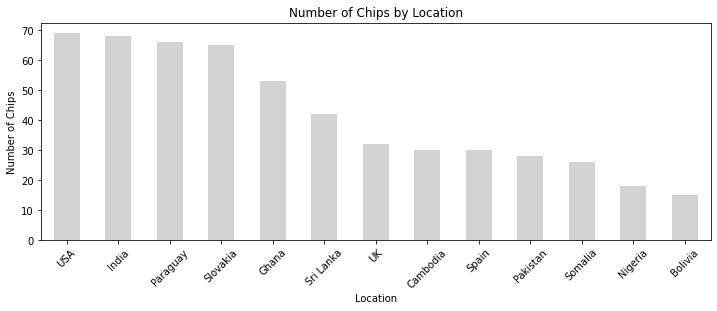

In [11]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

The data cover a wide geographic range. We have more than 60 chips for floods in the United States, India, Paraguay, and Slovakia.

Let's also take a look at when the images were originally captured.

In [12]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

In [13]:
train_metadata.groupby("flood_id")["scene_start"].nunique()

flood_id
awc    1
ayt    1
coz    1
hbe    1
hxu    1
jja    1
kuo    1
pxs    1
qus    1
qxb    1
tht    1
tnp    1
wvy    1
Name: scene_start, dtype: int64

The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

### Images

Next, we can begin exploring the image data!

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

**Recall that each set of two polarizations (vh and vh) correspond with a single water label.**

In [14]:
import rasterio

In [15]:
# Examine an arbitrary image
image_path = FEATURE_PATH / f"{train_metadata.image_id[0]}.tif"

In [16]:
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

In [17]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [18]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [19]:
data

array([[-16.208015 , -17.71951  , -16.281353 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.3288965, -18.231857 , -16.451893 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.353134 , -16.88831  , -15.585904 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-15.741662 , -15.230668 , -13.455255 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.498258 , -14.100984 , -13.11027  , ...,   0.       ,
          0.       ,   0.       ],
       [-16.055603 , -14.1121   , -14.76084  , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In `rasterio`, you can access two different kinds of missing data masks. The first mask is a [GDAL-style](https://gdal.org/) mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [20]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

In [21]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

The second mask is a [numpy masked array](http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html), which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [22]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

In [23]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [24]:
import warnings

warnings.filterwarnings("ignore")

In [25]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]

    # Extract paths to image files
    vv_path = FEATURE_PATH / f"{random_chip}_vv.tif"
    vh_path = FEATURE_PATH / f"{random_chip}_vh.tif"
    label_path = LABEL_PATH / f"{random_chip}.tif"

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

Let's inspect a few chips and their water labels.

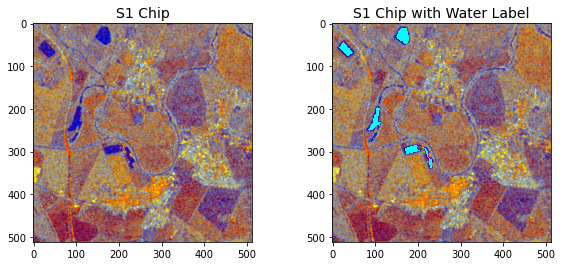

In [26]:
display_random_chip(7)

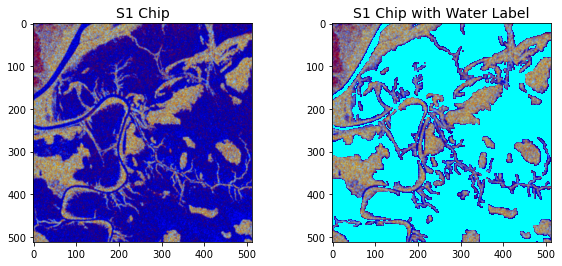

In [27]:
display_random_chip(66)

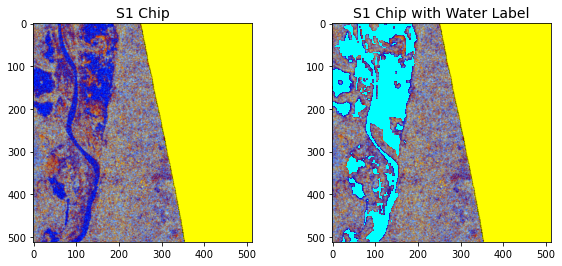

In [28]:
display_random_chip(90)

Pretty interesting!

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

Finally, let's confirm that the first few training images are the expected size of 512 x 512 pixels.

In [29]:
imgs = [FEATURE_PATH / f"{train_metadata.image_id[x]}.tif" for x in range(5)]
for img in imgs:
    print(rasterio.open(img).shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


For this benchmark, we will train a first pass model using Sentinel-1 imagery only. You are encouraged to incorporate supplementary elevation and permanent water source data into your own model training using the Planetary Computer STAC API.

<a id="section2"></a>

## Split the Data

The test set for this competition may include flood events not included in the training data. We do not want to overstate our model's performance by overfitting to one or more specific events. To be sure that our method is sufficiently generalizable, we will set aside a portion of the training imagery to validate the model during its development.

Since individual events are independent, we can randomly subset the training data into a training and validation using the `flood_id` field. For this benchmark, we will holdout three flood events or approximately one third of available images for our validation set. You are encouraged to think carefully about the implications of different holdouts when determining how best to validate your model.

In [30]:
import random

In [31]:
random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [32]:
val_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)].copy()
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)].copy()

In [33]:
# Confirm approx. 1/3 of chips are in the validation set
len(val_df) / (len(val_df) + len(train_df)) * 100

32.47232472324723

<a id="section3"></a>

## Build the Model

The goal of our first pass is to build a relatively simple model that takes radar imagery as input and outputs binary masks that indicate which pixels in a scene contain floodwater. Once we test this basic approach, we can attempt to improve our model by adding additional sophistication and complexity. We will use a lightweight PyTorch wrapper called [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) for this benchmark solution.

Rather than train an entire convolutional neural network (CNN) from scratch, we will tune a [U-Net](https://arxiv.org/abs/1505.04597) model for [semantic segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47). U-Net was first designed in 2015 to localize abnormalities in biomedical images. By applying a variety of data augmentation techniques, it can achieve high performance using relatively small training datasets. U-Net can be broadly thought of as an encoder network followed by a decoder network, where the encoder can be initialized using a [pretrained backbone](https://pytorch.org/vision/stable/models.html). For this exercise, we will initialize our encoder using [ResNet34](https://arxiv.org/abs/1512.03385). ResNet was prepared by Microsoft Research Asia in 2015 and is pretrained on the [ImageNet](https://image-net.org/) dataset.

First, we will need to read the training data into memory, convert the data to PyTorch tensors, and serve the data to our model in batches. Luckily, the PyTorch `Dataset` and `DataLoader` classes make implementing these complex tasks relatively straightforward. A `Dataset` object allows us to define custom methods for working with the data, and a `DataLoader` object parallelizes data loading. If you haven't worked with these classes before, we highly recommend this short [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Our custom dataset will inherit an abstract class called `torch.utils.data.Dataset` and [override](https://www.tutorialspoint.com/overriding-methods-in-python) the following methods:

- `__len__()`: returns the length of the dataset, measured as number of samples
- `__getitem__()`: provided as index, returns a sample from the dataset

The dataset object will return samples as dictionaries with keys for:

- `chip_id`: the chip id
- `chip`: a two-band image tensor (VV and VH)
- `label`: the label mask, if it exists

In [34]:
import torch

In [35]:
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, metadata, feature_dir, label_dir=None, transforms=None):
        self.chip_ids = metadata.chip_id.tolist()
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip_id
        chip_id = self.chip_ids[idx]
        vv_path = self.feature_dir / f"{chip_id}_vv.tif"
        vh_path = self.feature_dir / f"{chip_id}_vh.tif"
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label_dir is not None:
            label_path = self.label_dir / f"{chip_id}.tif"
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentations to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr

        return sample

Our custom dataset normalizes input pixel values by applying [min-max normalization](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_.28min-max_normalization.29) with a minimum of -77 and a maximum of 26.

To prevent overfitting during training, we'll increase the size of our training data by applying a set of data augmentations to our input, including random cropping, random 90 degree rotations, and horizontal and vertical flipping. The image augmentation library [albumentations](https://albumentations.ai/) is a helpful resource for this task.

In [36]:
# If running on the Planetary Computer, uncomment below
# !pip install albumentations

In [37]:
import albumentations

In [38]:
# These transformations will be passed to our model class
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

Next, we will create a custom class to define our training loss function and a helper function to calculate our validation metric, [Intersection over Union (IOU)](https://en.wikipedia.org/wiki/Jaccard_index).

For training, we will use a standard mixture of 50% [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) and 50% [dice loss](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), which improves learning when there are unbalanced classes. Since our images tend to contain more non-water than water pixels, this metric should be a good fit. Broadly speaking, cross-entropy loss evaluates differences between predicted and ground truth pixels and averages over all pixels, while dice loss measures overlap between predicted and ground truth pixels and divides a function of this value by the total number of pixels in both images. This custom class will inherit `torch.nn.Module`, which is the [base class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) for all neural network modules in PyTorch. A lower `XEDiceLoss` score indicates better performance.

For validation, we will calculate IOU. As a reminder, IOU represents the size of the intersection divided by the size of the union of pixels. A higher IOU indicates better performance.

In [39]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where(~valid_pixel_mask, 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [40]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

Given our new `FloodDataset`, PyTorch Lightning will allow us to train a model using minimal for loops. This library keeps the flexibility of PyTorch but removes most of the boilerplate training code, making it less error prone, cleaner to read, and easier to update. By subclassing `pl.LightningModule`, most of the training logic will happen for us behind the scenes. We can simply define what a `forward` call and `training_step` are, and provide our model with a `train_dataloader` to serve the data to our model. Behavior like [checkpoint saving](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.model_checkpoint.html) and [early stopping](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.early_stopping.html) are easily parameterized.

We define the following methods within our model:

- `forward`: define the forward pass for an image
- `training_step`: switch the model to train mode, implement the forward pass, and calculate training loss for a batch
- `validation_step`: switch the model to eval mode and calculate the validation metric for a batch
- `train_dataloader`: call an iterable over the training dataset for automatic batching
- `val_dataloader`: call an iterable over the validation dataset for automatic batching
- `configure_optimizers`: configure an [optimizer](https://pytorch.org/docs/stable/optim.html) and a [scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) to dynamically adjust the learning rate based on the number of epochs; this step automatically calls `backward` and `step` in each epoch
- `validation_epoch_end`: Reset the global tracker

We'll also add a couple of additional, optional, helper methods:

- `_build_df`: instantiate `FloodDataset` objects for training and validation
- `_prepare_model`: initialize a pretrained U-Net model
- `_get_trainer_params`: prepare checkpoint and early stopping behavior
- `fit`: fit a `pl.Trainer` object for training automation

In [41]:
# If running on the Planetary Computer, uncomment below
# !pip install pytorch_lightning

In [42]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

In [43]:
class FloodModel(pl.LightningModule):
    def __init__(self, train_metadata, val_metadata, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.feature_dir = self.hparams.get("feature_dir")
        self.label_dir = self.hparams.get("label_dir")
        self.train_chip_ids = self.hparams.get("train_chip_ids")
        self.val_chip_ids = self.hparams.get("val_chip_ids")
        self.transform = training_transformations
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.fast_dev_run = self.hparams.get("fast_dev_run", False)
        self.val_sanity_checks = self.hparams.get("val_sanity_checks", 0)
        self.gpu = self.hparams.get("gpu", False)
        
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model_outputs")
        self.output_path.mkdir(exist_ok=True)
        self.log_path = Path.cwd() / hparams.get("log_path", "tensorboard_logs")
        self.log_path.mkdir(exist_ok=True)
        
        # Instantiate training and val datasets
        self.train_dataset = self._build_df(train_metadata, group="train")
        self.val_dataset = self._build_df(val_metadata, group="val")

        # Instantiate model and trainer params
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0


    ## Required LightningModule methods ##


    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss", xe_dice_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler, "interval": "epoch", "monitor": "iou_epoch",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

    
    ## Convenience Methods ##


    def _build_df(self, metadata, group):
        # Instantiate datasets
        if group == "train":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=self.transform
            )
        elif group == "val":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=None
            )
        return df
    
    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=2,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="iou_epoch",
            mode="max",
            verbose=True,
        )
        # Define early stopping behavior
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="iou_epoch",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )
        # Specify where TensorBoard logs will be saved
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")
        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.fast_dev_run,
            "num_sanity_val_steps": self.val_sanity_checks,
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

<a id="section4"></a>

## Fit the Model

Finally, it's time to fit our model. A `FloodModel` can be instantiated using a dictionary of `hparams`. The only required `hparams` are the feature directory and the label directory, but there are several additional hyperparameters we can specify to explore modeling strategies, including the learning rate, patience, and batch size. Consider experimenting with different models and using hyperparameter tuning to find the best combination of parameters to improve performance.

Once we specify our `hparams`, we can simply call the `fit` method to begin training!

In [44]:
hparams = {
    # Required hparams
    "feature_dir": FEATURE_PATH,
    "label_dir": LABEL_PATH,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 2,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model_outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

In [45]:
flood_model = FloodModel(train_metadata=train_df, val_metadata=val_df, hparams=hparams)
flood_model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.734    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved. New best score: 0.133
Epoch 0, global step 22: iou_epoch reached 0.13326 (best 0.13326), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=0-step=22.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 45: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.026 >= min_delta = 0.0. New best score: 0.159
Epoch 2, global step 68: iou_epoch reached 0.15931 (best 0.15931), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=2-step=68-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.162
Epoch 3, global step 91: iou_epoch reached 0.16172 (best 0.16172), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=3-step=91-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 114: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 137: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.165
Epoch 6, global step 160: iou_epoch reached 0.16504 (best 0.16504), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=6-step=160.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.070 >= min_delta = 0.0. New best score: 0.235
Epoch 7, global step 183: iou_epoch reached 0.23535 (best 0.23535), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=7-step=183.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 206: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 229: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.003 >= min_delta = 0.0. New best score: 0.239
Epoch 10, global step 252: iou_epoch reached 0.23882 (best 0.23882), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=10-step=252.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.013 >= min_delta = 0.0. New best score: 0.252
Epoch 11, global step 275: iou_epoch reached 0.25158 (best 0.25158), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=11-step=275.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 298: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.010 >= min_delta = 0.0. New best score: 0.261
Epoch 13, global step 321: iou_epoch reached 0.26109 (best 0.26109), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=13-step=321-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.038 >= min_delta = 0.0. New best score: 0.300
Epoch 14, global step 344: iou_epoch reached 0.29953 (best 0.29953), saving model to "/home/jovyan/PlanetaryComputerExamples/model_outputs/epoch=14-step=344.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 367: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 390: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 413: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 436: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 459: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 482: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 505: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 528: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 551: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 574: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 597: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric iou_epoch did not improve in the last 12 records. Best score: 0.300. Signaling Trainer to stop.
Epoch 26, global step 620: iou_epoch was not in top 1


PyTorch Lightning lets you log PyTorch models and metrics into a directory for visualization within the [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) UI. TensorBoard is a machine learning visualization toolkit that's helpful for tracking metrics across batches, epochs, and models.

Locally, you can install TensorBoard through the command line to visualize your logged data. If you're working on the Planetary Computer, transfer the contents of the `tensorboard_logs/benchmark_model` directory to your local machine and run `$ tensorboard --logdir=tensorboard_logs/benchmark_model`.

In [46]:
flood_model.trainer_params["callbacks"][0].best_model_score

tensor(0.2995, device='cuda:0')

Our best validation IOU is **0.2995**.

<a id="section5"></a>

## Prepare for Submission

Now that our model is trained, we can finally prepare our submission. For this competition, your inference *code* will be executed to generate a score. This means that we'll need to save our model, write inference code, package everything up, and upload `submission.zip` to the competition [submissions page](https://www.drivendata.org/competitions/81/detect-flood-water/submissions/).

Let's walk through the process. Below we will:

1. Create a `benchmark-pytorch/` directory with an `benchmark-pytorch/assets` subdirectory to store our trained model and weights
2. Write a `main.py` file to load our model and weights, perform inference on images stored in `data/test_features`, generate chip-level predictions, and save predictions to `submission/` (see an example `main.py` file [here](https://github.com/drivendataorg/floodwater-runtime/blob/main/benchmark/main.py))
2. `zip` the contents of `benchmark-pytorch/` (not the directory itself) into a file called `submission.zip`
3. Upload `submission.zip` to the competition submissions page; the file will be unzipped and `main.py` will be run in a [containerized execution environment](https://github.com/drivendataorg/floodwater-runtime) to obtain our model's IOU

**Note:** If you'd like to look at this benchmark submission already completed, you can see the end product at the [runtime repo](https://github.com/drivendataorg/floodwater-runtime/tree/main/benchmark-pytorch).

<hr>

First, let's make the `benchmark-pytorch/` directory and its `benchmark-pytorch/assets` subdirectory.

In [47]:
submission_path = Path("benchmark-pytorch")
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

Next, let's save our model and weights.

In Pytorch, the learnable parameters of a model including its weights and biases are contained in it's parameters. A `state_dict` is a Python dictionary object that maps each layer to its parameter tensor. PyTorch provides a handy `model.save()` method for serializing our model's `state_dict` and, in turn, saving our model's weights.

In [48]:
weight_path = submission_assets_path / "flood_model.pt"
torch.save(flood_model.state_dict(), weight_path)

To load our trained model in the competition runtime environment, we'll save a simplified `FloodModel` class to `benchmark-pytorch/flood_model.py`. This model class will instantiate a generic U-Net model and will contain a helper method to perform inference for a given chip.

In [49]:
%%file benchmark-pytorch/flood_model.py
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch


class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=2,
            classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

Overwriting benchmark-pytorch/flood_model.py


The next step is to generate our `main.py` script in the root of our `benchmark-pytorch/` directory. The [code submission format page](https://www.drivendata.org/competitions/81/detect-flood-water/page/389/) contains helpful guidance for creating `main.py`. This file assumes that `FloodModel` can be imported from `flood_model.py`.

**Note:** For each test chip geography, supplementary elevation and permanent water images are available as static resources in the `/codeexecution/data/` directory. You have access to seven subdirectories, which each contain a single image per test chip. To use supplementary data for inference, simply load these images by their respective `chip_id`.

In [50]:
%%file benchmark-pytorch/main.py
import os
from pathlib import Path

from loguru import logger
import numpy as np
from tifffile import imwrite
from tqdm import tqdm
import torch
import typer

from flood_model import FloodModel


ROOT_DIRECTORY = Path("/codeexecution")
SUBMISSION_DIRECTORY = ROOT_DIRECTORY / "submission"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"
# EXAMPLE_NASADEM_DIRECTORY = DATA_DIRECTORY / "nasadem"

# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")


def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    logger.info("Starting inference.")
    try:
        vv_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vv.tif"
        vh_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vh.tif"
        # example_nasadem_path = EXAMPLE_NASADEM_DIRECTORY / f"{chip_id}.tif"
        # etc.
        output_prediction = model.predict(vv_path, vh_path)
    except Exception as e:
        logger.error(f"No bands found for {chip_id}. {e}")
        raise
    return output_prediction


def get_expected_chip_ids():
    """
    Use the test features directory to see which images are expected.
    """
    paths = INPUT_IMAGES_DIRECTORY.glob("*.tif")
    # Return one chip id per two bands (VV/VH)
    ids = list(sorted(set(path.stem.split("_")[0] for path in paths)))
    return ids


def main():
    """
    For each set of two input bands, generate an output file
    using the `make_predictions` function.
    """
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(ASSETS_DIRECTORY / "torch/hub")
    model = FloodModel()
    model.load_state_dict(torch.load(ASSETS_DIRECTORY / "flood_model.pt"))

    logger.info("Finding chip IDs")
    chip_ids = get_expected_chip_ids()
    if not chip_ids:
        typer.echo("No input images found!")
        raise typer.Exit(code=1)

    logger.info(f"Found {len(chip_ids)} test chip_ids. Generating predictions.")
    for chip_id in tqdm(chip_ids, miniters=25):
        output_path = SUBMISSION_DIRECTORY / f"{chip_id}.tif"
        output_data = make_prediction(chip_id, model).astype(np.uint8)
        imwrite(output_path, output_data, dtype=np.uint8)

    logger.success(f"Inference complete.")


if __name__ == "__main__":
    typer.run(main)

Overwriting benchmark-pytorch/main.py


**We also need to copy the model that `segmentation-models-pytorch` saved to our computer.** The container doesn't have access to the Internet, so you are responsible for packaging up any local assets and pointing your code to them. In the `main.py` below, you will see that we set the `TORCH_HOME` environment variable to look at where our submission gets decompressed instead of its default (usually something like `~/.cache/torch`). See the [pytorch.hub docs](https://pytorch.org/docs/stable/hub.html) for more on this.

In [51]:
!cp -R ~/.cache/torch benchmark-pytorch/assets/

Now our submission directory looks like this:

In [52]:
!tree benchmark-pytorch/

benchmark-pytorch/
├── assets
│   ├── flood_model.pt
│   └── torch
│       └── hub
│           └── checkpoints
│               └── resnet34-333f7ec4.pth
├── flood_model.py
└── main.py

4 directories, 4 files


Finally, let's `zip` everything up, submit it, and get our score!

In [53]:
# Remember to avoid including the inference dir itself
!cd benchmark-pytorch && zip -r ../submission.zip *

updating: assets/ (stored 0%)
updating: assets/flood_model.pt (deflated 7%)
updating: assets/torch/ (stored 0%)
updating: assets/torch/hub/ (stored 0%)
updating: assets/torch/hub/checkpoints/ (stored 0%)
updating: assets/torch/hub/checkpoints/resnet34-333f7ec4.pth (deflated 7%)
updating: flood_model.py (deflated 58%)
updating: main.py (deflated 58%)


In [54]:
!du -h submission.zip

164M	submission.zip


## Upload Submission

We can now head over to the competition [submissions page](https://www.drivendata.org/competitions/81/detect-flood-water/submissions/) to submit our code and obtain our model's IOU!

<figure><center><img src="https://drivendata-public-assets.s3.amazonaws.com/c2s-score.png" width="500" height="40"></center></figure>

Our submission takes about 20 minutes to execute. We should see an IOU of **0.6255** on the leaderboard. That's a great start, but now it's to you to improve this score. We hope this benchmark solution provides a helpful framework for exploring the data, designing a machine learning pipeline, training a deep learning model, and preparing your code for submission.

Head over to the [STAC Overflow](https://www.drivendata.org/competitions/81/detect-flood-water/) challenge homepage to get started. We can't wait to see what you build!